In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

2022-03-15 08:25:18.955495: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 08:25:18.955539: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle=True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE)

Found 2152 files belonging to 3 classes.


2022-03-15 08:25:23.513744: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-15 08:25:23.514262: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-15 08:25:23.514375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-15 08:25:23.514478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-15 08:25:23.514572: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

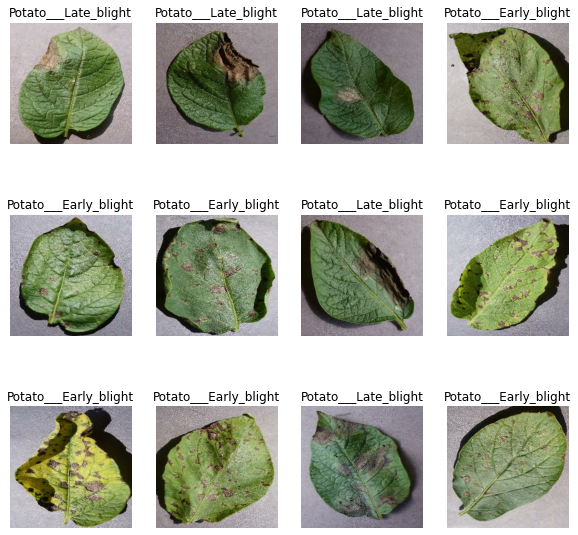

In [6]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [7]:
len(dataset)

68

In [8]:
train_size = 0.8
valid_size = 0.1
test_size = 0.1

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size=int(train_split*len(ds))
    train_ds=ds.take(train_size)
    
    valid_size=int(val_split*len(ds))
    valid_ds=ds.skip(train_size).take(valid_size)
    
    test_ds=ds.skip(train_size).skip(valid_size)
    
    return train_ds, valid_ds, test_ds

In [10]:
train_ds, valid_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(valid_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

In [15]:
resize_rescale = tf.keras.Sequential()
resize_rescale.add(tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE))
resize_rescale.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255))

flip_rotate = tf.keras.Sequential()
flip_rotate.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'))
flip_rotate.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.2))

model = tf.keras.Sequential([
    resize_rescale,
    flip_rotate,
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3 ), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3 ), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3 ), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3 ), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3,3 ), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(CHANNELS, activation='softmax')
])

model.build(input_shape=input_shape)

In [16]:
model.compile(
                optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])

In [17]:
with tf.device('/device:GPU:0'):
    history= model.fit(
                        train_ds,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=valid_ds
            )

Epoch 1/50
54/54 [==============================] - 111s 2s/step - loss: 0.9208 - accuracy: 0.4612 - val_loss: 0.8654 - val_accuracy: 0.4844
Epoch 2/50
54/54 [==============================] - 106s 2s/step - loss: 0.7571 - accuracy: 0.6140 - val_loss: 0.8314 - val_accuracy: 0.6562
Epoch 3/50
54/54 [==============================] - 108s 2s/step - loss: 0.5514 - accuracy: 0.7697 - val_loss: 0.5294 - val_accuracy: 0.7552
Epoch 4/50
54/54 [==============================] - 106s 2s/step - loss: 0.4493 - accuracy: 0.8148 - val_loss: 0.4545 - val_accuracy: 0.8281
Epoch 5/50
54/54 [==============================] - 114s 2s/step - loss: 0.3266 - accuracy: 0.8773 - val_loss: 0.2400 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 113s 2s/step - loss: 0.2395 - accuracy: 0.9144 - val_loss: 0.1592 - val_accuracy: 0.9635
Epoch 7/50
54/54 [==============================] - 111s 2s/step - loss: 0.1571 - accuracy: 0.9456 - val_loss: 0.2089 - val_accuracy: 0.9115
Epoch 8/50
54

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [19]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 6s 472ms/step - loss: 0.1163 - accuracy: 0.9648


In [20]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

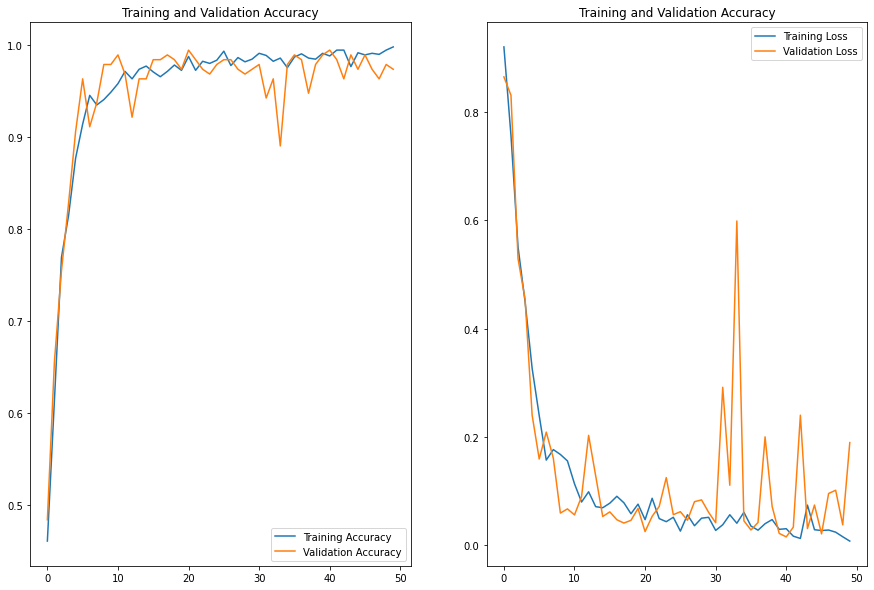

In [23]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

First Image
Actual Label:  Potato___healthy
Predicted Label:  Potato___healthy


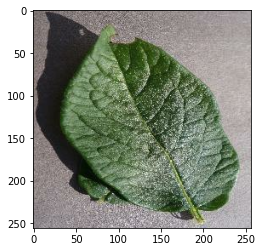

In [24]:
for images_batch, label_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()
    print('First Image')
    plt.imshow(first_image)
    print('Actual Label: ', class_names[first_label])
    predicted_batch = model.predict(images_batch)
    print('Predicted Label: ', class_names[np.argmax(predicted_batch[0])])

In [25]:
def predict(model, image):
    img_arr = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_arr = tf.expand_dims(img_arr, 0)
    
    predictions = model.predict(img_arr)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

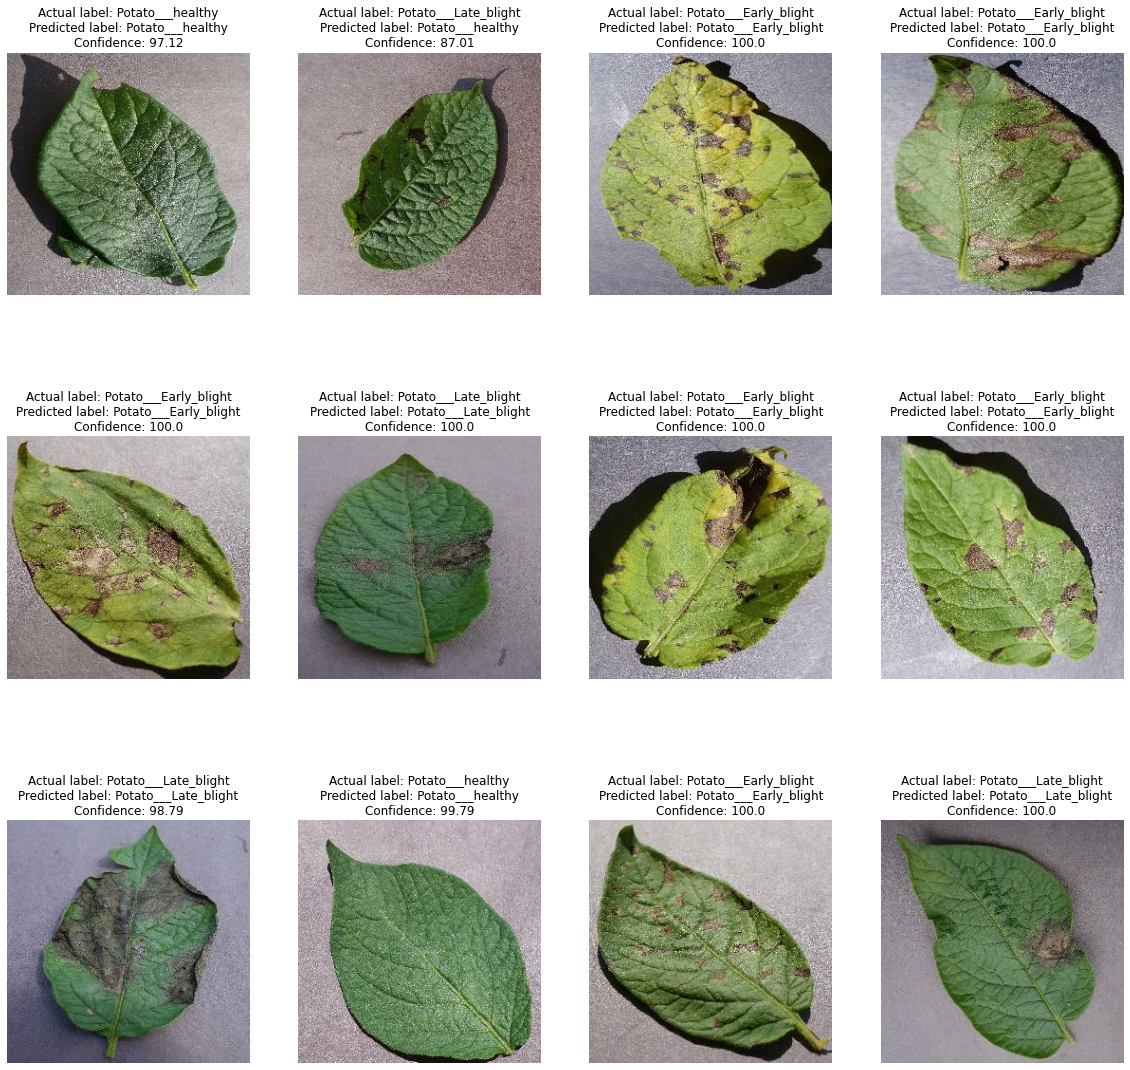

In [26]:
plt.figure(figsize=(20, 20))
for image_batch, label_batch in test_ds.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        
        predicted_class, confidence = predict(model, image_batch[i])
        plt.title("Actual label: {}\nPredicted label: {}\nConfidence: {}".format(
                                                                            class_names[label_batch[i].numpy()],
                                                                            predicted_class,
                                                                            confidence
                                                                            ))

In [27]:
model_version=1
model.save(f"../models/{model_version}")

2022-03-15 09:52:39.930328: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ../models/1/assets


In [28]:
# def count(stop):
#   i = 0
#   while i<stop:
#     yield i
#     i += 1

In [29]:
# ds_counter = tf.data.Dataset.from_generator(count, args=[25], output_types=tf.int32, output_shapes = (), )

In [30]:
# i = 0
# for count_batch in ds_counter.repeat().batch(10).take(10):
#     print(count_batch.numpy())
#     i += 1
#     if i == 3:
#         break